In [1]:
.L ../libAmBe.so

In [2]:
test

(const int) 11


In [3]:
char const* path {"../dataset/ambe2022.root"};
DataSetHolder dataset = ambeDataSet(path);

In [4]:
ROOT::RDF::RNode df = filterT1Events(dataset.df, 0.001);
df = df.Filter("is_event");
df = df.Redefine(
    "chainMaskT5",
    "ROOT::VecOps::Where(chainMaskT5==maskNOISE && (pdg == 1000020040 || pdg == 1000010030), ROOT::RVec (chainMaskT5.size(), -1), chainMaskT5)"
);

In [5]:
df = df.Define("chainMaskT9", "decayChainMask(T9.parentid, T9.trackid, T9.pdg, T9.CreatorProcessID, T9.initialEkin)");
df = createT5Mask(df);
double CountAll = df.Count().GetValue();

In [6]:
df = df.Define("volidNeutron", "volidEpvtTot(volid[chainMaskT5 == maskNOISE], E_quenched[chainMaskT5 == maskNOISE])");
df = df.Define("edep_pvtNeutron", "std::get<1>(volidNeutron)");
df = df.Redefine("volidNeutron", "std::get<0>(volidNeutron)");

In [7]:
df = df.Define("edep_pvtNeutronCut", "edep_pvtNeutron[edep_pvtNeutron < 4.2 && edep_pvtNeutron > 0.1]");
df = df.Define("volidNeutronCut", "volidNeutron[edep_pvtNeutron < 4.2 && edep_pvtNeutron > 0.1]");

# Energy distribution

In [8]:
ROOT::RDF::RNode dfedist = df.Define("NeutronTotalEnergy", "ROOT::VecOps::Sum(edep_pvtNeutronCut)");

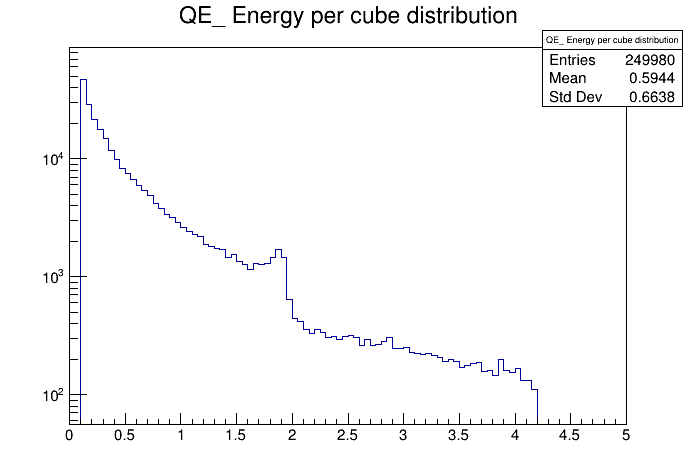

Info in <TCanvas::Print>: pdf file ../plots/pdf/QE_NeutronEnergy.pdf has been created
Info in <TCanvas::Print>: ps file ../plots/pgf/QE_NeutronEnergy.pgf has been created
Info in <TCanvas::Print>: png file ../plots/png/QE_NeutronEnergy.png has been created


In [9]:
TCanvas c;
auto hist = dfedist.Histo1D(
    {"QE_ Energy per cube distribution", "QE_ Energy per cube distribution", 100u, 0., 5.},
    "edep_pvtNeutronCut"
)->DrawClone();
c.SetLogy();
c.Draw();
std::string dir {"../plots"};
std::string file {"QE_NeutronEnergy"};
savePlot(hist, dir, file);

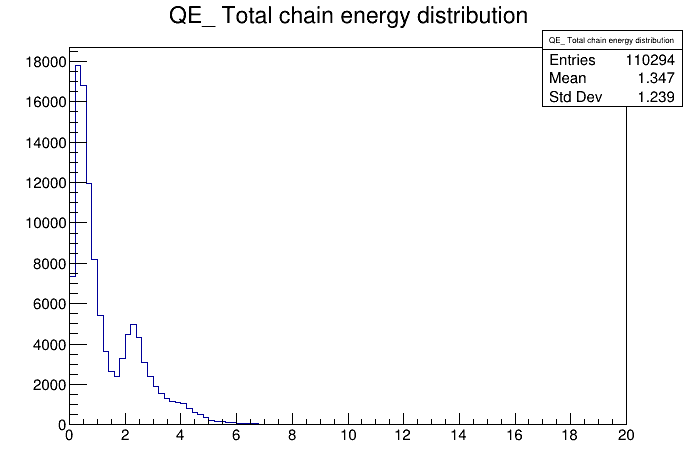

Info in <TCanvas::Print>: pdf file ../plots/pdf/QE_NeutronTotalEnergy.pdf has been created
Info in <TCanvas::Print>: ps file ../plots/pgf/QE_NeutronTotalEnergy.pgf has been created
Info in <TCanvas::Print>: png file ../plots/png/QE_NeutronTotalEnergy.png has been created


In [10]:
TCanvas c;
auto hist = dfedist.Filter("NeutronTotalEnergy").Histo1D({
    "QE_ Total chain energy distribution",
    "QE_ Total chain energy distribution",
    100u, 0., 20.
    }, "NeutronTotalEnergy")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"QE_NeutronTotalEnergy"};
savePlot(hist, dir, file);

# Number of cube

In [11]:
ROOT::RDF::RNode dfcount = df.Define("CubeCounter", "volidNeutronCut.size()");

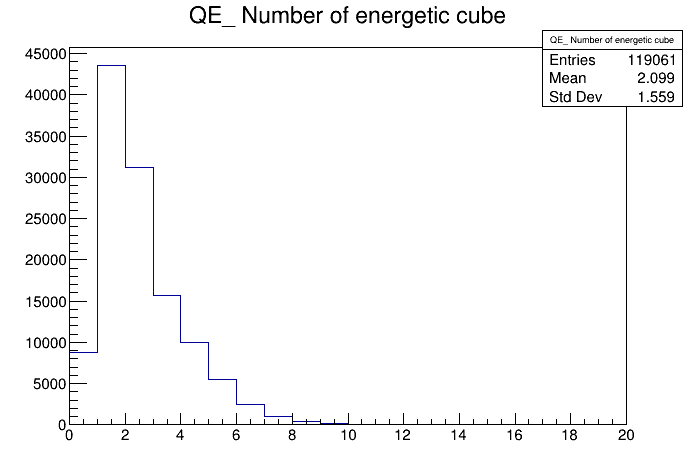

Info in <TCanvas::Print>: pdf file ../plots/pdf/QE_NeutronNumberCube.pdf has been created
Info in <TCanvas::Print>: ps file ../plots/pgf/QE_NeutronNumberCube.pgf has been created
Info in <TCanvas::Print>: png file ../plots/png/QE_NeutronNumberCube.png has been created


In [12]:
TCanvas c;
auto hist = dfcount.Histo1D({"QE_ Number of energetic cube", "QE_ Number of energetic cube", 20u, 0., 20.}, "CubeCounter")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"QE_NeutronNumberCube"};
savePlot(hist, dir, file);

In [13]:
double TriggerBreaking = dfcount.Filter("CubeCounter == 2").Count().GetValue();

In [14]:
TriggerBreaking / CountAll

(double) 0.26206734


# Distance distribution

In [15]:
ROOT::RDF::RNode dfdistance = df.Define("NeutronCoM", "centerOfMass(volidNeutronCut, edep_pvtNeutronCut)");

In [16]:
dfdistance = dfdistance.Filter("NeutronCoM  != -1").Define("NeutronDistFromCoM", "euclidDist(NeutronCoM, volidNeutronCut)");

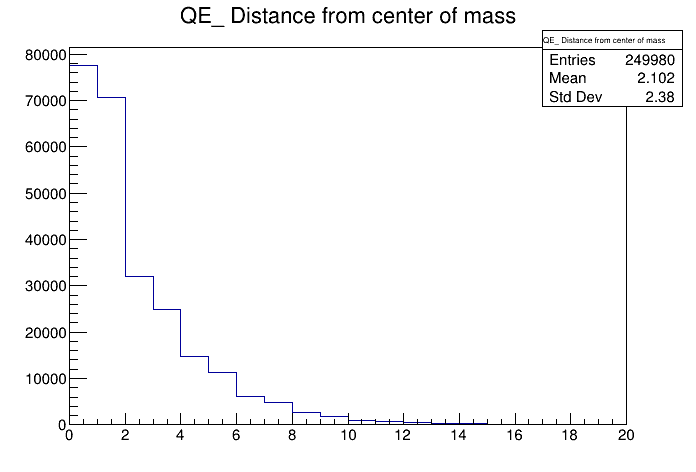

Info in <TCanvas::Print>: pdf file ../plots/pdf/QE_NeutronChainDistFromCoM.pdf has been created
Info in <TCanvas::Print>: ps file ../plots/pgf/QE_NeutronChainDistFromCoM.pgf has been created
Info in <TCanvas::Print>: png file ../plots/png/QE_NeutronChainDistFromCoM.png has been created


In [17]:
TCanvas c;
TObject* hist = dfdistance.Histo1D(
    {"QE_ Distance from center of mass", "QE_ Distance from center of mass", 20u, 0., 20.},
    "NeutronDistFromCoM"
)->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"QE_NeutronChainDistFromCoM"};
savePlot(hist, dir, file);

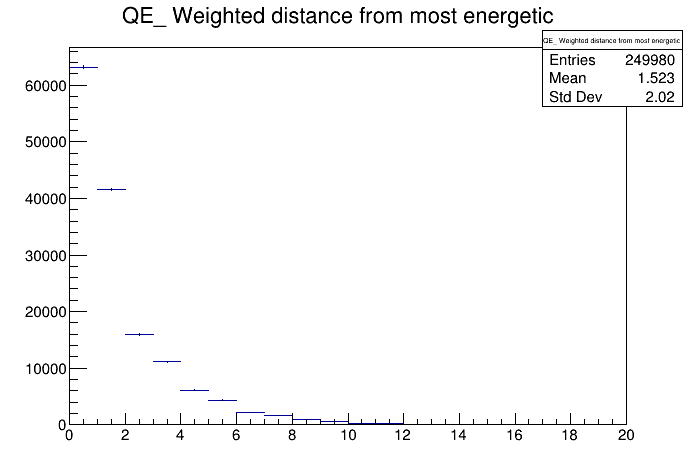

Info in <TCanvas::Print>: pdf file ../plots/pdf/QE_NeutronChainWDistFromMaxE.pdf has been created
Info in <TCanvas::Print>: ps file ../plots/pgf/QE_NeutronChainWDistFromMaxE.pgf has been created
Info in <TCanvas::Print>: png file ../plots/png/QE_NeutronChainWDistFromMaxE.png has been created


In [18]:
TCanvas c;
auto hist = dfdistance.Histo1D<ROOT::RVec<double>, ROOT::RVec<double>>(
    {"QE_ Weighted distance from most energetic", "QE_ Weighted distance from most energetic", 20u, 0., 20.0},
    "NeutronDistFromCoM", "edep_pvtNeutronCut"
)->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"QE_NeutronChainWDistFromMaxE"};
savePlot(hist, dir, file);

In [19]:
dfdistance = dfdistance.Define("volidCE", "volidEpvtTot(volid[chainMaskT5 == maskCE_ELECT || chainMaskT5 == maskCE_CHILD], edep_pvt[chainMaskT5 == maskCE_ELECT || chainMaskT5 == maskCE_CHILD])");
dfdistance = dfdistance.Define("edep_pvtCE", "std::get<1>(volidCE)");
dfdistance = dfdistance.Redefine("volidCE", "std::get<0>(volidCE)");

In [20]:
dfdistance = dfdistance.Define("edep_pvtCECut", "edep_pvtCE[edep_pvtCE < 4.2 && edep_pvtCE > 0.1]");
dfdistance = dfdistance.Define("volidCECut", "volidCE[edep_pvtCE < 4.2 && edep_pvtCE > 0.1]");

In [21]:
dfdistance = dfdistance.Define("__indexMaxCEMostEnergetic", "indexMax<double>(edep_pvtCECut)");
dfdistance = dfdistance.Filter("__indexMaxCEMostEnergetic !=-1").Define("CEMostEnergetic", "volidCECut[__indexMaxCEMostEnergetic]");

In [22]:
ROOT::RVec<int> a { 1, 2, 3};
a[-1] // shit

(int) 12


In [23]:
dfdistance = dfdistance.Define("CE_NeutronDist", "euclidDist(CEMostEnergetic, {NeutronCoM})");

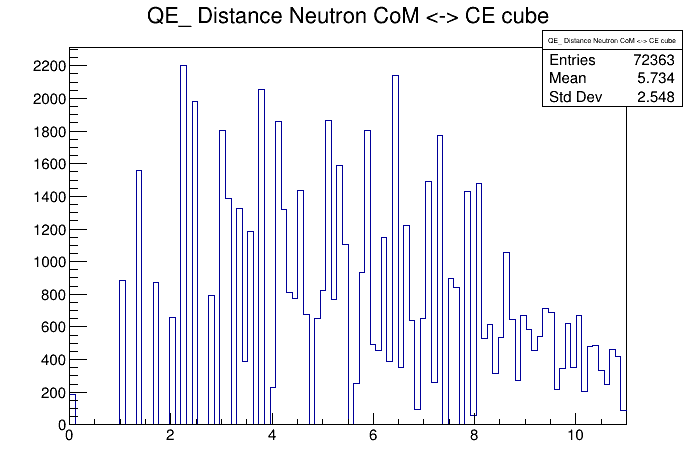

Info in <TCanvas::Print>: pdf file ../plots/pdf/QE_NeutronCEDistance.pdf has been created
Info in <TCanvas::Print>: ps file ../plots/pgf/QE_NeutronCEDistance.pgf has been created
Info in <TCanvas::Print>: png file ../plots/png/QE_NeutronCEDistance.png has been created


In [24]:
TCanvas c;
auto hist = dfdistance.Histo1D(
    {"QE_ Distance Neutron CoM <-> CE cube", "QE_ Distance Neutron CoM <-> CE cube", 100u, 0., 11.},
    "CE_NeutronDist"
)->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"QE_NeutronCEDistance"};
savePlot(hist, dir, file);

In [25]:
dfdistance = dfdistance.Filter("ROOT::VecOps::All(CE_NeutronDist > 20)");

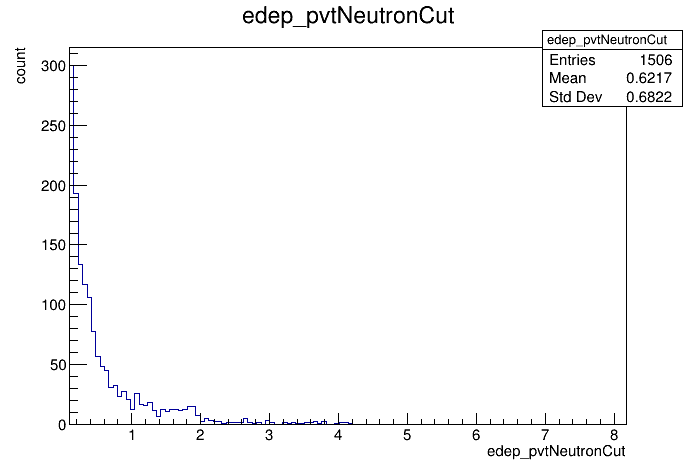

In [26]:
TCanvas c;
auto hist = dfdistance.Histo1D("edep_pvtNeutronCut");
hist->DrawClone();
c.Draw();

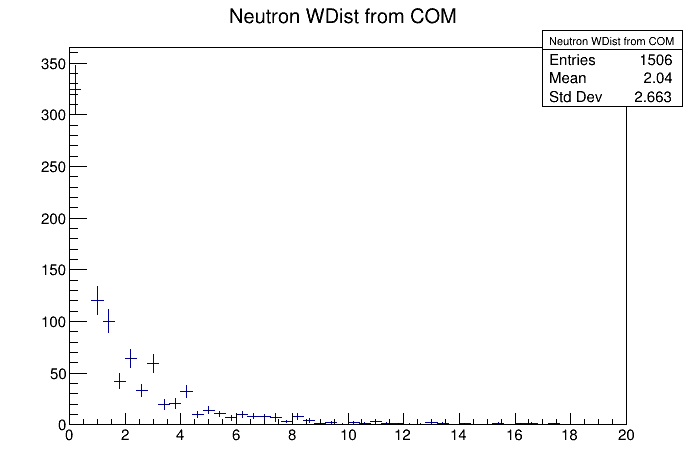

In [27]:
TCanvas c;
dfdistance.Histo1D<ROOT::RVec<double>, ROOT::RVec<double>>({"Neutron WDist from COM", "Neutron WDist from COM", 50u, 0., 20.0}, "NeutronDistFromCoM", "edep_pvtNeutronCut")->DrawClone();
c.Draw();